In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Chargement des données
dat_quarterly = pd.read_excel("date_quarterly.xlsx")
default_rate_quarterly = pd.read_excel("default_rate_quarterly.xlsx")
variables_macroeconomiques = pd.read_excel("variables_macroeconomiques.xlsx")
variables_macroeconomiques_adverse = pd.read_excel("variables_macroeconomiques_adverse.xlsx")
variables_macroeconomiques_baseline = pd.read_excel("variables_macroeconomiques_baseline.xlsx")

In [2]:
df = pd.merge(default_rate_quarterly, variables_macroeconomiques, on='Date', how='left')

In [3]:
print(default_rate_quarterly['Date'].min())
print(default_rate_quarterly['Date'].max())

2010-01-31 00:00:00
2019-10-31 00:00:00


In [4]:
print(variables_macroeconomiques['Date'].min())
print(variables_macroeconomiques['Date'].max())

2009-01-31 00:00:00
2020-10-31 00:00:00


In [5]:
print((df['Date'].min()))
print((df['Date'].max()))

2010-01-31 00:00:00
2019-10-31 00:00:00


In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.optimize import minimize

# Calcule de la distance au défaut (DD) en niveau
df['DD'] = df['DR']

Etude statistique des variables

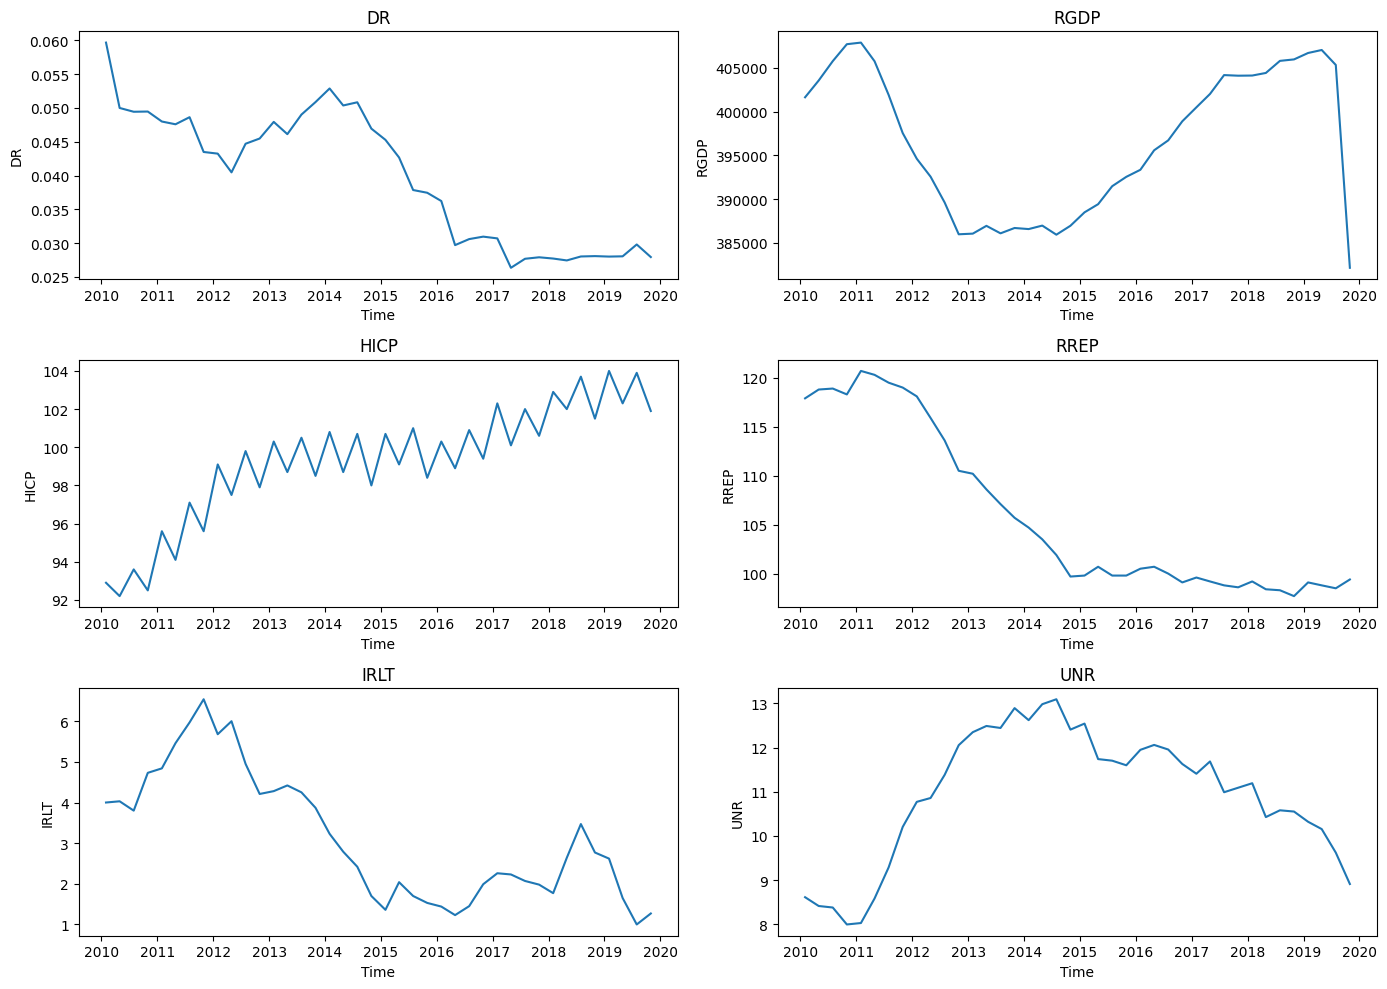

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# etude des tendances et des caractéristiques des données
# les séries temporelles des variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
for ax, col in zip(axes.flatten(), df.columns[1:]):
    sns.lineplot(data=df, x='Date', y=col, ax=ax)
    ax.set_title(f"{col}")
    ax.set_ylabel(col)
    ax.set_xlabel("Time")
fig.tight_layout()
plt.show()

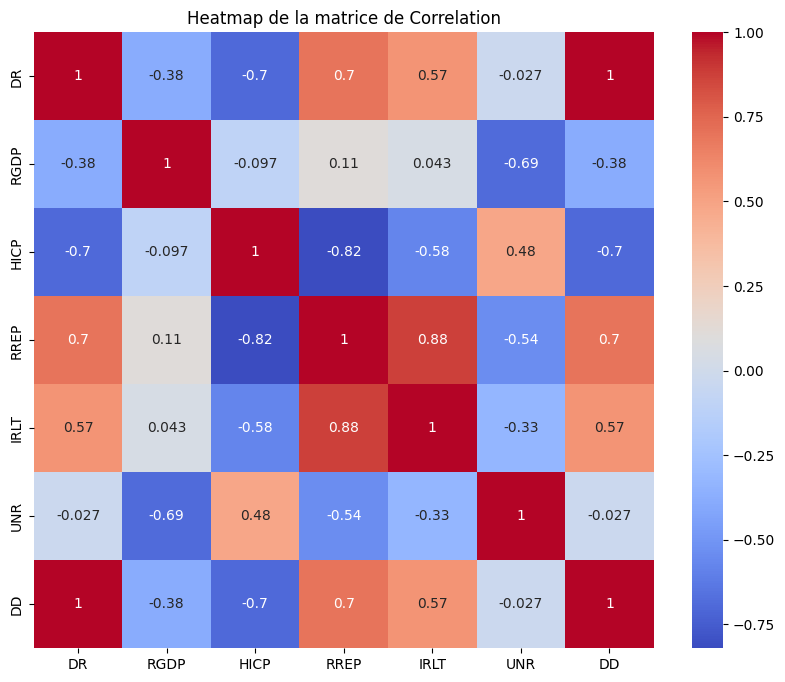

In [8]:
# Analyse des relations entre les variables macroéconomiques et DR_t
# Création d'une heatmap pour visualiser la corrélation entre les variables
corr_matrix = df.iloc[:,1:].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Heatmap de la matrice de Correlation")
plt.show()

DR_t : La tendance baissière globale du taux de défaut (DR) pourrait indiquer une amélioration de la situation économique au fil du temps, avec une exception en 2012 où il y a eu une augmentation significative des défauts pour atteindre un pic en 2014. La stabilité entre 2017 et 2020 pourrait suggérer une période de stabilité économique.

RGDP : La croissance du PIB réel (RGDP) montre des fluctuations au fil du temps, avec une croissance initiale, une récession et une reprise jusqu'en 2019, suivie d'un effondrement en 2019. Les variations du RGDP pourraient être liées à des événements économiques mondiaux et locaux, et peuvent avoir un impact sur les taux de défaut. La corrélation négative entre DR_t et RGDP (-0,38) indique que les taux de défaut ont tendance à diminuer lorsque le RGDP augmente, ce qui est conforme à l'intuition économique.

HICP : L'indice des prix à la consommation harmonisé (HICP) montre une tendance haussière avec une saisonnalité claire. La corrélation négative entre DR_t et HICP (-0,70) suggère que les taux de défaut ont tendance à diminuer lorsque l'inflation augmente. Cela peut sembler contre-intuitif, mais il est possible que des facteurs externes tels que les politiques monétaires influent sur cette relation.
On peut également considerer que les defauts ont tendance à augmenter en période euphorie et d'inflation comme on a pu l'observer dans l'histoire economique.

RREP : Les taux de rendement des obligations d'État (RREP) montrent une baisse initiale, puis une période de stabilité. La corrélation positive entre DR_t et RREP (0,70) indique que les taux de défaut ont tendance à augmenter lorsque les taux de rendement des obligations d'État augmentent. Cela pourrait suggérer que les investisseurs considèrent les obligations d'État comme plus risquées en période de taux de défaut élevés.

IRLT : Les taux d'intérêt à long terme (IRLT) montrent une tendance initiale à la hausse, puis une baisse avec des fluctuations jusqu'en 2020. La corrélation positive entre DR_t et IRLT (0,57) suggère que les taux de défaut ont tendance à augmenter lorsque les taux d'intérêt à long terme augmentent, ce qui peut refléter un environnement économique moins favorable pour les emprunteurs.

UNR : Le taux de chômage (UNR) montre une tendance globale à la baisse avec des fluctuations. La corrélation faible entre DR_t et UNR (-0,03) indique qu'il n'y a pas de relation claire entre les taux de défaut et le taux de chômage. Cela pourrait signifier que d'autres facteurs ont un impact plus important sur les taux de défaut.

### En résumé

Il semble que les variables macroéconomiques les plus pertinentes pour expliquer les variations des taux de défaut sont HICP, RREP et IRLT, qui présentent des corrélations significatives avec DR_t. Les autres variables, bien que présentant des tendances intéressantes, ont des corrélations moins fortes avec DR_t et pourraient être moins importantes pour notre analyse.

Cependant, nous devons prendre en compte les relations entre les variables macroéconomiques elles-mêmes pour éviter une forte corrélation entre ces variables, ce qui pourrait indiquer une colinéarité et poser des problèmes dans certains modèles prédictifs.

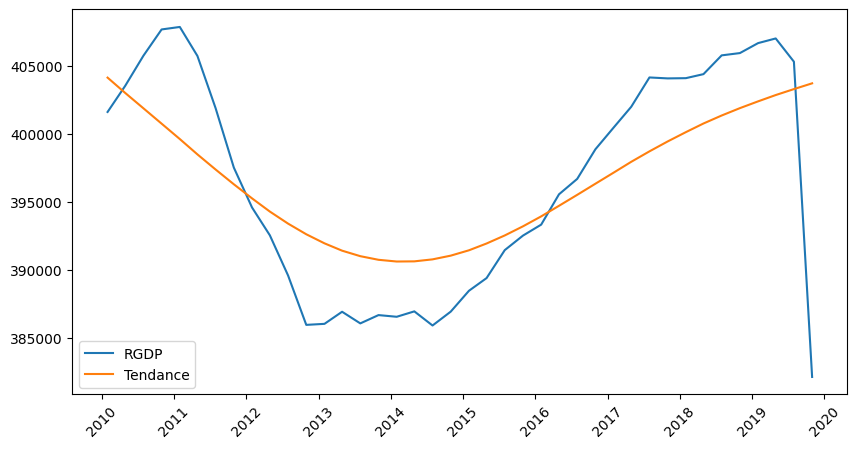

In [9]:
import statsmodels.api as sm
import matplotlib.dates as mdates

# Appliquer le filtre de Hodrick-Prescott à la série RGDP
rgdp_cycle, rgdp_trend = sm.tsa.filters.hpfilter(df['RGDP'], lamb=1600)

# Créer une figure et des axes
fig, ax = plt.subplots(figsize=(10,5))

# Tracer la série temporelle et la tendance
ax.plot(df['Date'], df['RGDP'], label='RGDP')
ax.plot(df['Date'], rgdp_trend, label='Tendance')
ax.legend()

# Configurer les axes
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=45)

plt.show()


Le graphique montre la série temporelle de la variable RGDP (produit intérieur brut réel) avec une estimation de la tendance à l'aide de la méthode de Hodrick-Prescott. La ligne orange représente la tendance de long terme de la série RGDP, tandis que la ligne bleue montre la série temporelle réelle de RGDP. En utilisant cette méthode, nous pouvons identifier les périodes où la série RGDP est en-dessous ou au-dessus de sa tendance de long terme, ce qui peut donner des indications sur les phases de récession et d'expansion de l'économie.

#### Méthode de Hodrick-Prescott pour séparer la tendance à long terme de la variation à court terme

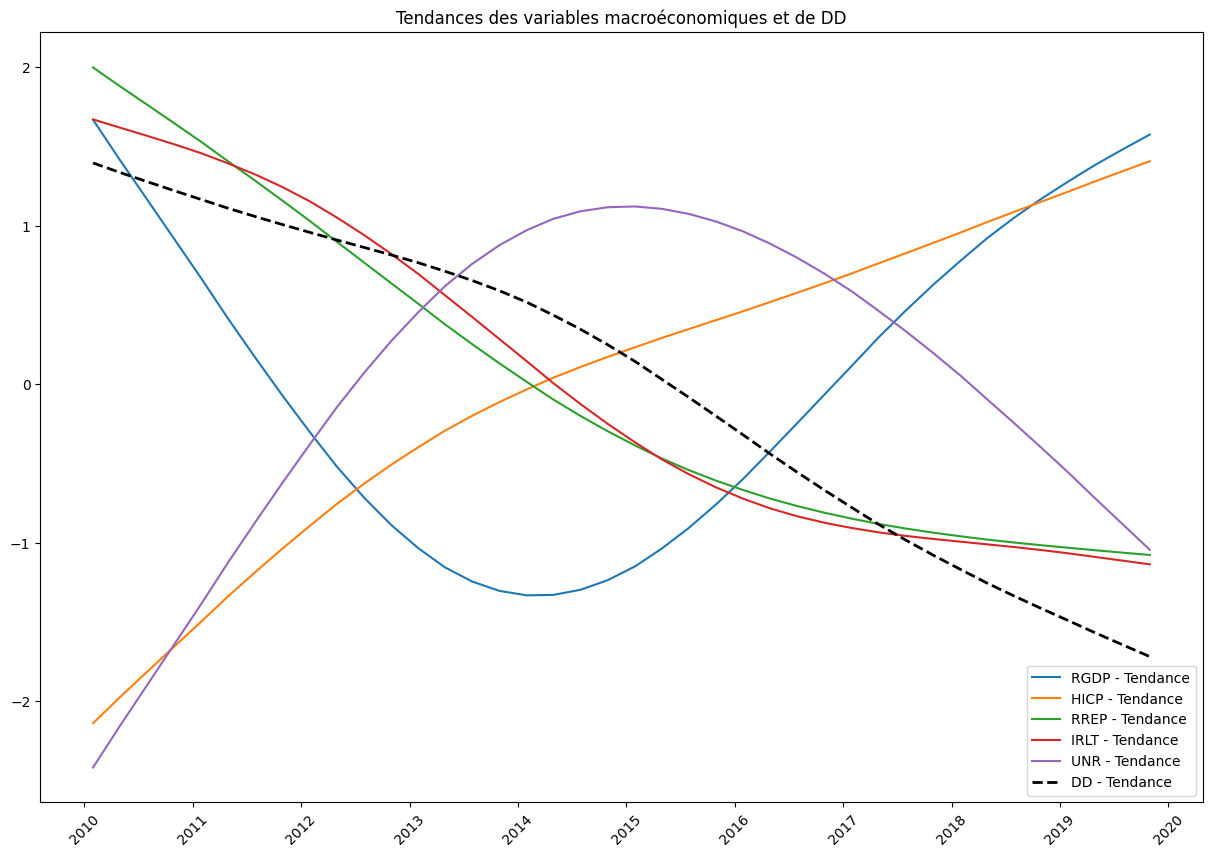

In [10]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Appliquer le filtre de Hodrick-Prescott à chaque série temporelle
rgdp_cycle, rgdp_trend = sm.tsa.filters.hpfilter(df['RGDP'], lamb=1600)
hicp_cycle, hicp_trend = sm.tsa.filters.hpfilter(df['HICP'], lamb=1600)
rrep_cycle, rrep_trend = sm.tsa.filters.hpfilter(df['RREP'], lamb=1600)
irlt_cycle, irlt_trend = sm.tsa.filters.hpfilter(df['IRLT'], lamb=1600)
unr_cycle, unr_trend = sm.tsa.filters.hpfilter(df['UNR'], lamb=1600)
dd_cycle, dd_trend = sm.tsa.filters.hpfilter(df['DD'], lamb=1600)

# Normaliser les séries temporelles
rgdp_trend_norm = (rgdp_trend - rgdp_trend.mean()) / rgdp_trend.std()
hicp_trend_norm = (hicp_trend - hicp_trend.mean()) / hicp_trend.std()
rrep_trend_norm = (rrep_trend - rrep_trend.mean()) / rrep_trend.std()
irlt_trend_norm = (irlt_trend - irlt_trend.mean()) / irlt_trend.std()
unr_trend_norm = (unr_trend - unr_trend.mean()) / unr_trend.std()
dd_trend_norm = (dd_trend - dd_trend.mean()) / dd_trend.std()

# Créer une figure et des axes
fig, ax = plt.subplots(figsize=(15,10))

# Tracer la série temporelle et la tendance pour chaque variable macroéconomique
ax.plot(df['Date'], rgdp_trend_norm, label='RGDP - Tendance')
ax.plot(df['Date'], hicp_trend_norm, label='HICP - Tendance')
ax.plot(df['Date'], rrep_trend_norm, label='RREP - Tendance')
ax.plot(df['Date'], irlt_trend_norm, label='IRLT - Tendance')
ax.plot(df['Date'], unr_trend_norm, label='UNR - Tendance')

# Ajouter la série DD et sa tendance avec un style de ligne différent
ax.plot(df['Date'], dd_trend_norm, label='DD - Tendance', linestyle='--', linewidth=2, color='black')

# Configurer les axes
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=45)

# Ajouter une légende et un titre
ax.legend()
ax.set_title('Tendances des variables macroéconomiques et de DD')

plt.show()



Ce graphique représente les tendances normalisées des variables macroéconomiques (RGDP, HICP, RREP, IRLT et UNR) et du taux de défaut (DD) 
sur la période 2010-2020. Chaque courbe représente la tendance de la variable respective, filtrée à l'aide de la méthode de Hodrick-Prescott pour 
séparer la tendance à long terme de la variation à court terme. La normalisation de chaque série temporelle permet de mettre en évidence la variation relative 
de chaque variable par rapport à sa propre moyenne et écart-type au fil du temps.

## Etude de stationnarité

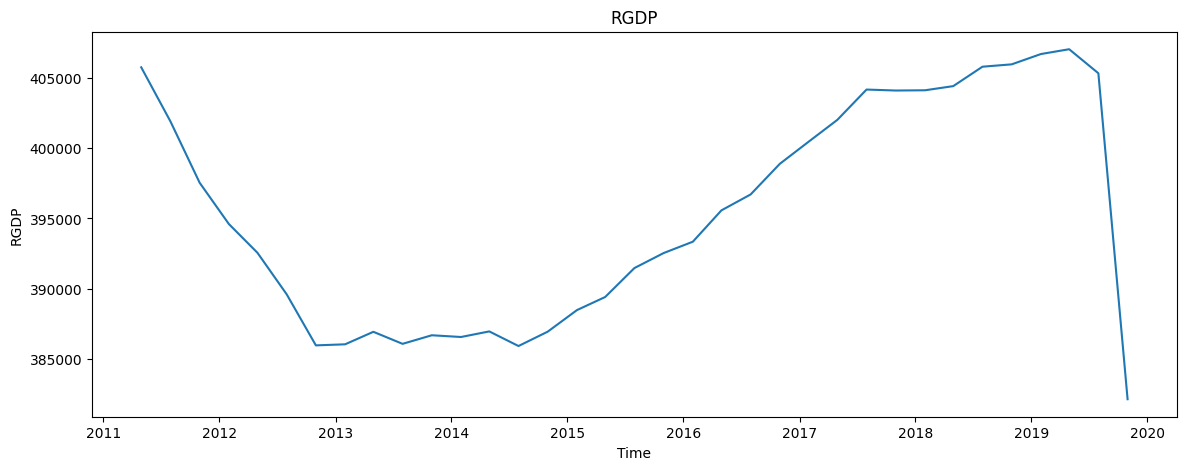

In [148]:
# Plot de DR
fig, ax = plt.subplots(figsize=(14, 5))
sns.lineplot(data=df, x='Date', y=df.columns[1], ax=ax)
ax.set_title(f"{df.columns[1]}")
ax.set_ylabel(df.columns[1])
ax.set_xlabel("Time")
plt.show()

### Recherche du bêta optimal pour la différenciation partielle

c:\Users\bouzo\anaconda3\envs\RCredit\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\bouzo\anaconda3\envs\RCredit\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\bouzo\anaconda3\envs\RCredit\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\bouzo\anaconda3\envs\RCredit\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values availab

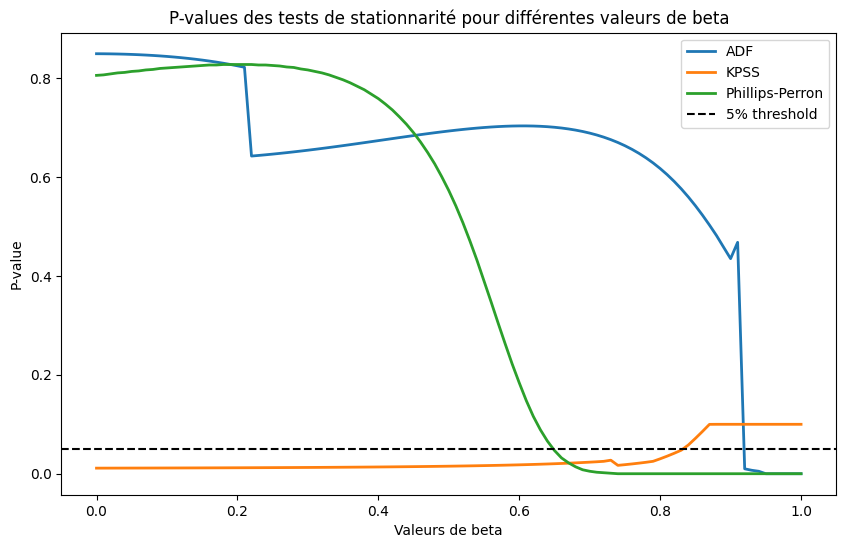

Betas rendant la série stationnaire: [0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0]


In [11]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
import matplotlib.pyplot as plt

def partial_differencing(beta, series):
    return series - beta * series.shift(1)

def test_stationarity(series):
    n = len(series)
    lags_adf = int(12 * (n / 100) ** 0.25)  # Règle de Schwert pour les retards ADF
    
    adf_result = adfuller(series, maxlag=lags_adf)
    kpss_result = kpss(series, regression='c', nlags='auto')
    pp_result = PhillipsPerron(series, lags=lags_adf).summary().as_text()
    pp_p_value = float(pp_result.split("P-value")[1].split()[0])
    
    stationary_tests_passed = 0
    
    if adf_result[1] < 0.05:
        stationary_tests_passed += 1
    if kpss_result[1] > 0.05:
        stationary_tests_passed += 1
    if pp_p_value < 0.05:
        stationary_tests_passed += 1
        
    return stationary_tests_passed >= 2, adf_result[1], kpss_result[1], pp_p_value


# Application de la différenciation partielle avec différents bêtas
betas = np.arange(0, 1.01, 0.01)
stationary_betas = []
adf_p_values = []
kpss_p_values = []
pp_p_values = []

for beta in betas:
    differenced_series = partial_differencing(beta, df['DD']).dropna()
    
    if test_stationarity(differenced_series)[0]:
        stationary_betas.append(beta)
    
    adf_p_values.append(test_stationarity(differenced_series)[1])
    kpss_p_values.append(test_stationarity(differenced_series)[2])
    pp_p_values.append(test_stationarity(differenced_series)[3])

# Plot des p-values
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(betas, adf_p_values, label="ADF", linewidth=2)
ax.plot(betas, kpss_p_values, label="KPSS", linewidth=2)
ax.plot(betas, pp_p_values, label="Phillips-Perron", linewidth=2)
ax.axhline(y=0.05, color="black", linestyle="--", label="5% threshold")
ax.set_xlabel("Valeurs de beta")
ax.set_ylabel("P-value")
ax.set_title("P-values des tests de stationnarité pour différentes valeurs de beta")
ax.legend()

plt.show()

print("Betas rendant la série stationnaire:", stationary_betas)


In [12]:
beta_optimal = 0.84
df['DD_diff'] = partial_differencing(beta_optimal, df['DD']).dropna()
df.dropna(inplace=True)

Vérification de la stationnarité de la série différenciée

In [13]:
# Vérification de la stationnarité à nouveau avec le test kpss
adf_result = kpss(df['DD_diff'].dropna(), regression='c', nlags='auto')
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF Statistic: 0.4442254842368667
p-value: 0.05809246369100574


Sélection des meilleurs lags pour la série différenciée et les variables macroéconomiques

       Analyse des fonctions d'autocorrélation (ACF) et d'autocorrélation partielle (PACF)

c:\Users\bouzo\anaconda3\envs\RCredit\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


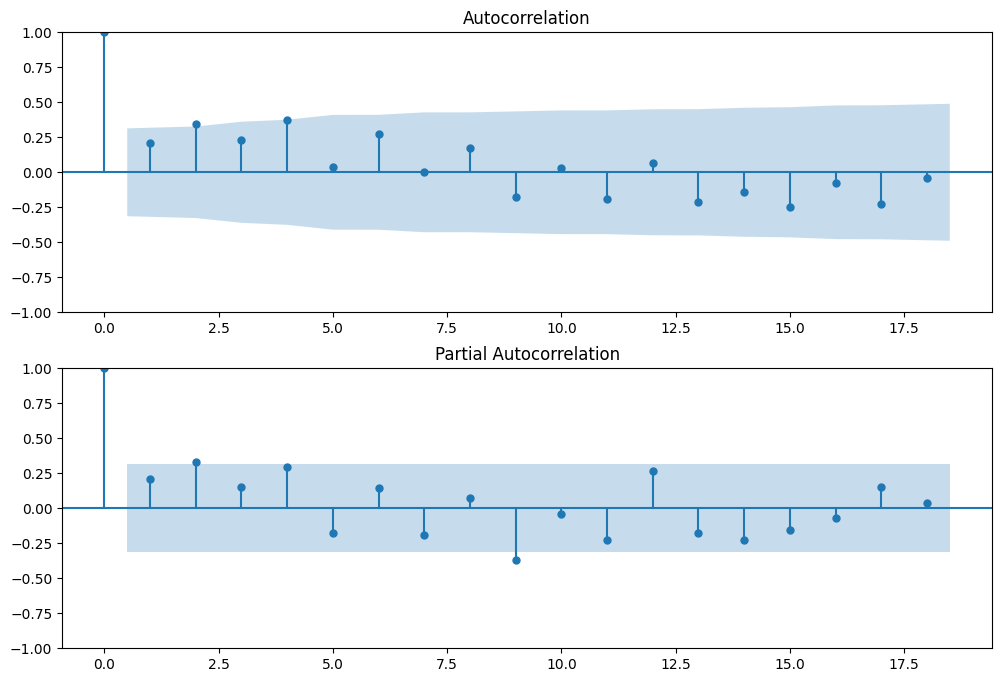

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Sélection des meilleurs lags pour la série elle-même en utilisant ACF et PACF
series = df['DD_diff'].dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(series, lags=18, ax=ax1)
plot_pacf(series, lags=18, ax=ax2)

plt.show()

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from itertools import combinations


         Sélection des meilleurs lags pour chaque variable macroéconomique en utilisant la corrélation croisée:

In [16]:
max_lags = 4
lags = np.arange(1, max_lags+1)
macro_vars = ['RGDP', 'HICP', 'RREP', 'IRLT', 'UNR']
best_lags = {}

for var in macro_vars:
    max_corr = 0
    best_lag = 0
    for lag in lags:
        df[f'{var}_lag{lag}'] = df[var].shift(lag)
        corr = df['DD_diff'].corr(df[f'{var}_lag{lag}'])
        if abs(corr) > abs(max_corr):
            max_corr = corr
            best_lag = lag
    best_lags[var] = best_lag

print("Meilleurs lags pour chaque variable macroéconomique:", best_lags)


Meilleurs lags pour chaque variable macroéconomique: {'RGDP': 1, 'HICP': 1, 'RREP': 4, 'IRLT': 3, 'UNR': 4}


In [17]:
# Création des colonnes retardées pour DD_diff
df['DD_diff_lag1'] = df['DD_diff'].shift(1)
df['DD_diff_lag2'] = df['DD_diff'].shift(2)
df.dropna(inplace=True)

In [18]:
df=df.drop(['DR','DD'], axis=1)

Sélection des meilleures variables explicatives

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Préparation des données
X = df.drop(columns=['DD_diff','Date'])
y = df['DD_diff']

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fonction pour évaluer les performances d'un modèle
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Fonction pour sélectionner les meilleures variables explicatives
def select_best_variables(X_train, y_train, X_test, y_test):
    all_vars = X_train.columns
    best_vars = []
    best_r2 = -np.inf

    for var in all_vars:
        current_vars = best_vars + [var]
        model = LinearRegression()
        model.fit(X_train[current_vars], y_train)
        
        _, r2 = evaluate_model(model, X_test[current_vars], y_test)
        
        if r2 > best_r2:
            best_r2 = r2
            best_vars.append(var)

    return best_vars, best_r2

best_vars, best_r2 = select_best_variables(X_train, y_train, X_test, y_test)
print("Les meilleures variables explicatives sont:", best_vars)
print("Le R2 associé est:", best_r2)

Les meilleures variables explicatives sont: ['RGDP', 'RREP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1', 'DD_diff_lag2']
Le R2 associé est: 0.7874578018349963


Estimation du modèle OLS

In [20]:
import statsmodels.api as sm

# Ajouter une constante à X_train et X_test
X_train = sm.add_constant(X_train[best_vars])
X_test = sm.add_constant(X_test[best_vars])

# le modèle OLS
model = sm.OLS(y_train, X_train).fit()

print(model.summary())

# les prédictions sur les données de test
y_pred = model.predict(X_test)

# Calcule des métriques de performance
mse, r2 = evaluate_model(model, X_test, y_test)
print("MSE sur les données de test:", mse)
print("R2 sur les données de test:", r2)

                            OLS Regression Results                            
Dep. Variable:                DD_diff   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     2.976
Date:                Wed, 12 Apr 2023   Prob (F-statistic):             0.0455
Time:                        19:22:33   Log-Likelihood:                 126.48
No. Observations:                  24   AIC:                            -225.0
Df Residuals:                      10   BIC:                            -208.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1767      0.161     -1.099   

Estimation du modèle BMA (Bayesian Model Averaging)

In [21]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import r2_score
# from sklearn.model_selection import train_test_split
# from itertools import chain, combinations
# import statsmodels.api as sm

# # Préparation des données
# X = df.drop(columns=['DD_diff', 'Date'])
# y = df['DD_diff']

# # Séparation des données en ensembles d'entraînement et de test pour prédire sur la dernière année 2019
# train_df = df[df['Date'] < '2019-01-01']
# test_df = df[df['Date'] >= '2019-01-01']

# X_train = train_df.drop(columns=['DD_diff', 'Date'])
# y_train = train_df['DD_diff']

# X_test = test_df.drop(columns=['DD_diff', 'Date'])
# y_test = test_df['DD_diff']

# # Variables sélectionnées
# selected_vars = ['RGDP', 'RREP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1','DD_diff_lag2']

# # Génération de toutes les combinaisons de variables sélectionnées
# variable_combinations = list(chain(*map(lambda x: combinations(selected_vars, x), range(1, len(selected_vars) + 1))))

# # Fonction pour entraîner le modèle OLS et calculer le R2
# def fit_and_score_model(variables, X_train, y_train, X_test, y_test):
#     X_train = sm.add_constant(X_train[list(variables)])
#     X_test = sm.add_constant(X_test[list(variables)])
#     model = sm.OLS(y_train, X_train)
#     results = model.fit()
#     y_pred = results.predict(X_test)
#     r2 = r2_score(y_test, y_pred)
#     return r2, results, list(variables)

# # Entraînement du modèle OLS pour chaque combinaison de variables et calcule du R2
# models_and_r2 = [fit_and_score_model(vars, X_train, y_train, X_test, y_test) for vars in variable_combinations]

# # Trier les modèles par R2 décroissant
# models_and_r2.sort(key=lambda x: x[0], reverse=True)

# # Sélection des N meilleurs modèles en fonction 
# N = 10
# top_n_models_and_r2 = models_and_r2[:N]

# # Calculer les poids pour le BMA en utilisant le R2
# weights = np.array([r2 for r2, _, _ in top_n_models_and_r2])
# weights = weights / weights.sum()

# # Prédire les valeurs pour l'ensemble de test en utilisant le BMA
# y_pred_bma = np.zeros(y_test.shape)
# for i, (_, model, used_columns) in enumerate(top_n_models_and_r2):
#     X_test_bma = sm.add_constant(X_test[used_columns])
#     y_pred_bma += weights[i] * model.predict(X_test_bma)

# # Calculer le R2 pour le BMA
# r2_bma = r2_score(y_test, y_pred_bma)
# print("Le R2 pour le BMA est:", r2_bma)


In [22]:
print((df['Date'].min()))
print((df['Date'].max()))

2011-04-30 00:00:00
2019-10-31 00:00:00


In [23]:
# import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from itertools import chain, combinations
import statsmodels.api as sm

# Préparation des données
X = df.drop(columns=['DD_diff', 'Date'])
y = df['DD_diff']

# Séparation des données en ensembles d'entraînement et de test pour prédire sur la dernière année 2019
train_df = df[df['Date'] < '2019-01-01']
test_df = df[df['Date'] >= '2019-01-01']

X_train = train_df.drop(columns=['DD_diff', 'Date'])
y_train = train_df['DD_diff']

X_test = test_df.drop(columns=['DD_diff', 'Date'])
y_test = test_df['DD_diff']

# Variables sélectionnées
selected_vars = ['RGDP', 'RREP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1','DD_diff_lag2']

N=10

In [34]:
def BMA(X_train, y_train, X_test, y_test, selected_vars, N):
    # Génération de toutes les combinaisons de variables sélectionnées
    variable_combinations = list(chain(*map(lambda x: combinations(selected_vars, x), range(1, len(selected_vars) + 1))))

    # Fonction pour entraîner le modèle OLS et calculer le R2
    def fit_and_score_model(variables, X_train, y_train, X_test, y_test):
        X_train = sm.add_constant(X_train[list(variables)])
        X_test = sm.add_constant(X_test[list(variables)])
        model = sm.OLS(y_train, X_train)
        results = model.fit()
        y_pred = results.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        return r2, results, list(variables)

    # Entraînement du modèle OLS pour chaque combinaison de variables et calcule du R2
    models_and_r2 = [fit_and_score_model(vars, X_train, y_train, X_test, y_test) for vars in variable_combinations]

    # Trier les modèles par R2 décroissant
    models_and_r2.sort(key=lambda x: x[0], reverse=True)

    # Sélection des N meilleurs modèles en fonction de R2
    top_n_models_and_r2 = models_and_r2[:N]

    # Calcul des poids pour le BMA en utilisant le R2
    weights = np.array([r2 for r2, _, _ in top_n_models_and_r2])
    weights = weights / weights.sum()

    # Prédiction des valeurs pour l'ensemble de test en utilisant le BMA
    y_bma = np.zeros(y_test.shape)
    for i, (_, model, used_columns) in enumerate(top_n_models_and_r2):
        X_test_bma = sm.add_constant(X_test[used_columns])
        y_bma += weights[i] * model.predict(X_test_bma)

    # Calcul de R2 pour le BMA
    r2_bma = r2_score(y_test, y_bma)
    print("Le R2 pour le BMA est:", r2_bma)
    
    # les prédictions du modèle BMA pour y_test
    return y_bma

In [35]:
y_bma = BMA(X_train, y_train, X_test, y_test, selected_vars, N)

Le R2 pour le BMA est: 0.8166339967390825


### Etude modele

In [26]:

from scipy.stats import normaltest
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox, breaks_cusumolsresid

# Calculez les résidus
residuals = y_test - y_bma

In [27]:
from scipy.stats import shapiro

# 1. Test de normalité des résidus (test de Shapiro-Wilk)
sw_stat, sw_pvalue = shapiro(residuals)
print("Test de Shapiro-Wilk : Statistique = {:.4f}, p-value = {:.4f}".format(sw_stat, sw_pvalue))

Test de Shapiro-Wilk : Statistique = 0.9717, p-value = 0.8518


Le test de Shapiro-Wilk évalue si les résidus suivent une distribution normale. Dans ce cas, la statistique est de 0.9717 et la p-value est de 0.8518. Puisque la p-value est supérieure à 0.05, nous ne pouvons pas rejeter l'hypothèse nulle, ce qui signifie qu'il n'y a pas de preuve solide pour suggérer que les résidus ne suivent pas une distribution normale. Cela est conforme à l'hypothèse de normalité des résidus dans un modèle linéaire.

In [28]:
# 2. Test d'homoscédasticité (test de Breusch-Pagan)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, X_test)
print("Test de Breusch-Pagan : Statistique = {:.4f}, p-value = {:.4f}".format(bp_stat, bp_pvalue))

Test de Breusch-Pagan : Statistique = 4.0000, p-value = 1.0000


Le test de Breusch-Pagan évalue si les résidus présentent une hétéroscédasticité, c'est-à-dire une variance inégale. Dans ce cas, la statistique est de 4.0000 et la p-value est de 1.0000. Comme la p-value est supérieure à 0.05, nous ne pouvons pas rejeter l'hypothèse nulle, ce qui signifie qu'il n'y a pas de preuve solide pour suggérer que les résidus sont hétéroscédastiques. Cela est conforme à l'hypothèse d'homoscédasticité des résidus dans un modèle linéaire.

In [29]:
from statsmodels.tsa.stattools import acf
from scipy.stats import bartlett

# Calculez les autocorrélations pour un décalage de 1
autocorrelations = acf(residuals, nlags=1, fft=False)[1:]

# Effectuez le test de Bartlett pour les erreurs d'autocorrélation
bartlett_stat, bartlett_pvalue = bartlett(residuals[:-1], residuals[1:])
print("Test de Bartlett : Statistique = {:.4f}, p-value = {:.4f}".format(bartlett_stat, bartlett_pvalue))

Test de Bartlett : Statistique = 0.6666, p-value = 0.4143


Le test de Bartlett évalue si les résidus sont autocorrélés. Dans ce cas, la statistique est de 0.6666 et la p-value est de 0.4143. Puisque la p-value est supérieure à 0.05, nous ne pouvons pas rejeter l'hypothèse nulle, ce qui signifie qu'il n'y a pas de preuve solide pour suggérer que les résidus sont autocorrélés. Cela est conforme à l'hypothèse de non-autocorrélation des résidus dans un modèle linéaire.

En résumé, les résultats des tests suggèrent que les résidus du modèle BMA sont conformes aux hypothèses de base : normalité, homoscédasticité et non-autocorrélation. Cela indique que le modèle est bien ajusté aux données et que les erreurs ne présentent pas de problèmes majeurs qui pourraient remettre en question la validité du modèle.

### Projection sur Q1 2020 avec le modèle BMA

In [30]:
df_2020 = pd.merge(default_rate_quarterly, variables_macroeconomiques, on='Date', how='right')

df_2020 = df_2020.drop(range(4))
df_2020.head(4)

,Date,DR,RGDP,HICP,RREP,IRLT,UNR
4,2010-01-31,0.059661,401628.8,92.9,117.9,4.00,8.612495
5,2010-04-30,0.049995,403548.8,92.2,118.8,4.03,8.413377
6,2010-07-31,0.049434,405763.2,93.6,118.9,3.80,8.379038
7,2010-10-31,0.049466,407697.5,92.5,118.3,4.73,7.995356


In [31]:
# Calcule de la distance au défaut (DD) en niveau
df_2020['DD'] = df_2020['DR']


#Fonction de differenciation
def partial_differencing(beta, series):
    return series - beta * series.shift(1)

#Application de la fonction
beta_optimal = 0.84
df_2020['DD_diff'] = partial_differencing(beta_optimal, df_2020['DD'])

#Supprimer les colonne inutiles
df_2020 = df_2020.drop(index=4).reset_index(drop=True)
df_2020=df_2020.drop(['DD','DR'], axis=1)

In [32]:
lags = [1, 2, 3, 4]

# Création des variables décalées pour chaque variable dans df_2020
for lag in lags:
    for var in ['RGDP', 'HICP', 'RREP', 'IRLT', 'UNR', 'DD_diff']:
        df_2020[f'{var}_lag{lag}'] = df_2020[var].shift(lag)

# Sélection des variables nécessaires à partir de df_2020
selected_vars = ['RGDP', 'HICP', 'RREP', 'IRLT', 'UNR',
                 'RGDP_lag1', 'RGDP_lag2', 'RGDP_lag3', 'RGDP_lag4',
                 'HICP_lag1', 'HICP_lag2', 'HICP_lag3', 'HICP_lag4',
                 'RREP_lag1', 'RREP_lag2', 'RREP_lag3', 'RREP_lag4',
                 'IRLT_lag1', 'IRLT_lag2', 'IRLT_lag3', 'IRLT_lag4',
                 'UNR_lag1', 'UNR_lag2', 'UNR_lag3', 'UNR_lag4',
                 'DD_diff_lag1', 'DD_diff_lag2']

X = df_2020[selected_vars].iloc[4:].reset_index(drop=True)
y = df_2020['DD_diff'].iloc[4:].reset_index(drop=True)


X = X.dropna()
y = y.dropna()

In [33]:
def predict_BMA(X_train, y_train, X_test, selected_vars, N):
    variable_combinations = list(chain(*map(lambda x: combinations(selected_vars, x), range(1, len(selected_vars) + 1))))

    def fit_and_score_model(variables, X_train, y_train):
        X_train = sm.add_constant(X_train[list(variables)])
        model = sm.OLS(y_train, X_train)
        results = model.fit()
        return results, list(variables)

    models_and_r2 = [fit_and_score_model(vars, X_train, y_train) for vars in variable_combinations]
    models_and_r2.sort(key=lambda x: x[0].rsquared, reverse=True)

    top_n_models_and_r2 = models_and_r2[:N]

    weights = np.array([model.rsquared for model, _ in top_n_models_and_r2])
    weights = weights / weights.sum()

    y_pred_bma = 0
    for i, (model, used_columns) in enumerate(top_n_models_and_r2):
        X_test_bma = sm.add_constant(X_test[used_columns])
        print("i:", i)
        print("used_columns:", used_columns)
        print("X_test_bma.shape:", X_test_bma.shape)
        print("model.params.shape:", model.params.shape)
        
        if X_test_bma.shape[1] == model.params.shape[0] - 1:
            X_test_bma['const'] = 1
            used_columns = ['const'] + used_columns

        y_pred_bma += weights[i] * model.predict(X_test_bma[used_columns])

    return y_pred_bma.iloc[-1]

In [34]:
X_train = X.iloc[:-1, :]
y_train = y
X_test = X.iloc[[-1]]

selected_vars = ['RGDP', 'RREP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1', 'DD_diff_lag2']

N = 10

predicted_value = predict_BMA(X_train, y_train, X_test, selected_vars, N)
print("La valeur prédite pour Q1 2020 :", predicted_value)

i: 0
used_columns: ['RGDP', 'RREP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1', 'DD_diff_lag2']
X_test_bma.shape: (1, 13)
model.params.shape: (14,)
i: 1
used_columns: ['RREP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1', 'DD_diff_lag2']
X_test_bma.shape: (1, 12)
model.params.shape: (13,)
i: 2
used_columns: ['RGDP', 'RREP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'UNR_lag1', 'DD_diff_lag1', 'DD_diff_lag2']
X_test_bma.shape: (1, 12)
model.params.shape: (13,)
i: 3
used_columns: ['RGDP', 'RREP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'DD_diff_lag1', 'DD_diff_lag2']
X_test_bma.shape: (1, 12)
model.params.shape: (13,)
i: 4
used_columns: ['RREP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'DD_diff_lag

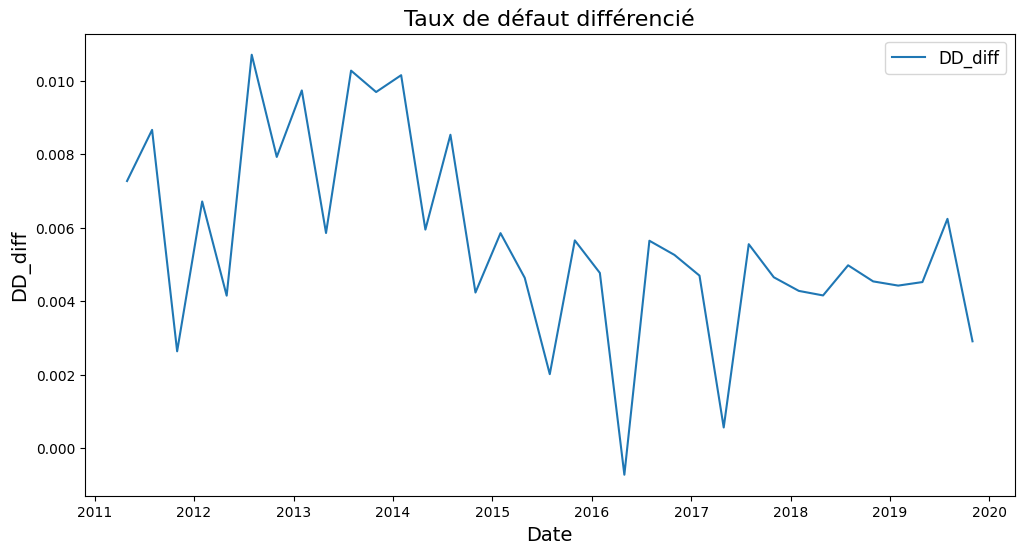

In [35]:
import matplotlib.pyplot as plt

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(12, 6))

# Tracé de la série temporelle
ax.plot(df['Date'], df['DD_diff'], label='DD_diff')

# Ajout des titres et des légendes
ax.set_title('Taux de défaut différencié', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('DD_diff', fontsize=14)
ax.legend(fontsize=12)


# Affichage du graphique
plt.show()

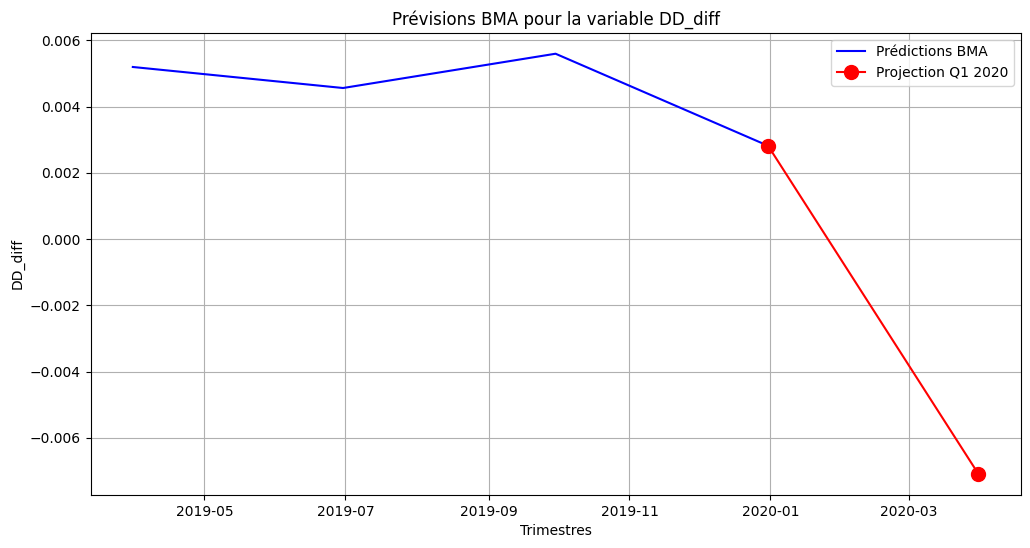

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Les dates des 4 derniers trimestres de 2019 et Q1 2020
dates = ['2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31', '2020-03-31']

# Les prédictions BMA et la projection pour Q1 2020
y_bma_updated = list(y_bma) + [-0.0070862631555927025]

# Création d'un DataFrame avec les dates et les prédictions
predictions_df = pd.DataFrame({'Date': dates, 'Predictions': y_bma_updated})
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(12, 6))

# Tracé des prédictions BMA pour les 4 premiers trimestres
ax.plot(predictions_df['Date'][:-1], predictions_df['Predictions'][:-1], label='Prédictions BMA', color='blue')

# Tracé de la projection pour le dernier trimestre
ax.plot(predictions_df['Date'][-2:], predictions_df['Predictions'][-2:], marker='o', markersize=10, color='red', label='Projection Q1 2020')

# Paramètres du graphique
ax.set_xlabel('Trimestres')
ax.set_ylabel('DD_diff')
ax.set_title('Prévisions BMA pour la variable DD_diff')
ax.legend(loc='best')
ax.grid(True)

# Affichage du graphique
plt.show()


# Matrice de migration

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pyreadstat
from datetime import datetime, timedelta

In [25]:
def read_sas_file(file_path):
    df, meta = pyreadstat.read_sas7bdat(file_path)
    return df

base_1 = read_sas_file('base_1.sas7bdat')
base_2 = read_sas_file('base_2.sas7bdat')

base_1['dtf_per_trt'] = base_1['dtf_per_trt'].apply(lambda x: datetime(1960, 1, 1) + timedelta(days=x))
base_2['dtf_per_trt'] = base_2['dtf_per_trt'].apply(lambda x: datetime(1960, 1, 1) + timedelta(days=x))

In [26]:
print(base_1["dtf_per_trt"].min())
print(base_1["dtf_per_trt"].max())
print(base_1["classe"].min())
print(base_1["classe"].max())

2010-01-31 00:00:00
2017-12-31 00:00:00
1.0
11.0


In [27]:
print(base_2["dtf_per_trt"].min())
print(base_2["dtf_per_trt"].max())
print(base_2["classe"].min())
print(base_2["classe"].max())

2018-01-31 00:00:00
2020-12-31 00:00:00
1.0
11.0


In [28]:
def build_transition_matrix(df, date_col, id_col, rating_col):
    df = df[[date_col, id_col, rating_col]].drop_duplicates()
    df['next_rating'] = df.groupby(id_col)[rating_col].shift(-1)
    df = df.dropna()
    matrix = pd.crosstab(df[rating_col], df['next_rating'], normalize='index')
    return matrix

# Fusion des bases de données base_1 et base_2
full_base = pd.concat([base_1, base_2])

# Construction de la matrice de référence
reference_matrix = build_transition_matrix(full_base, 'dtf_per_trt', 'ID_BCR_TRS', 'classe')

In [29]:
reference_matrix

next_rating,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
classe,,,,,,,,,,,
1.0,0.967324,0.016152,0.012968,0.002764,0.000265,0.000418,0.000061,0.000025,0.000014,0.000003,0.000005
2.0,0.022921,0.960972,0.002204,0.003407,0.004274,0.005059,0.001021,0.000060,0.000062,0.000009,0.000011
3.0,0.004225,0.025886,0.958974,0.000580,0.000548,0.004159,0.004348,0.001105,0.000109,0.000049,0.000016
4.0,0.000191,0.012256,0.028190,0.945496,0.000800,0.001015,0.009543,0.000077,0.002293,0.000091,0.000048
5.0,0.000168,0.008038,0.006751,0.022004,0.948128,0.001049,0.010122,0.000378,0.003155,0.000140,0.000067
6.0,0.000238,0.000823,0.010730,0.001737,0.017381,0.948328,0.001788,0.011509,0.005202,0.002110,0.000156
7.0,0.000167,0.000948,0.001890,0.006560,0.007815,0.017575,0.926912,0.002020,0.019514,0.015877,0.000722
8.0,0.000130,0.000509,0.003241,0.001038,0.000908,0.026404,0.034769,0.866652,0.011702,0.052187,0.002461
9.0,0.000151,0.000865,0.001164,0.003859,0.005642,0.017066,0.066788,0.022012,0.762015,0.107041,0.013397


In [30]:
percentage_matrix = reference_matrix * 100
percentage_matrix

next_rating,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
classe,,,,,,,,,,,
1.0,96.732438,1.615162,1.296849,0.276370,0.026515,0.041801,0.006114,0.002505,0.001387,0.000317,0.000541
2.0,2.292094,96.097222,0.220380,0.340701,0.427390,0.505882,0.102050,0.005998,0.006235,0.000929,0.001118
3.0,0.422485,2.588587,95.897355,0.057954,0.054814,0.415936,0.434820,0.110511,0.010945,0.004949,0.001645
4.0,0.019124,1.225572,2.818967,94.549613,0.080033,0.101488,0.954254,0.007714,0.229333,0.009080,0.004821
5.0,0.016754,0.803769,0.675146,2.200434,94.812832,0.104900,1.012227,0.037751,0.315503,0.014028,0.006657
6.0,0.023770,0.082266,1.073024,0.173669,1.738098,94.832764,0.178757,1.150945,0.520152,0.210958,0.015599
7.0,0.016716,0.094761,0.188952,0.656028,0.781483,1.757509,92.691157,0.202017,1.951425,1.587725,0.072226
8.0,0.013030,0.050858,0.324065,0.103818,0.090789,2.640433,3.476865,86.665224,1.170163,5.218660,0.246096
9.0,0.015073,0.086539,0.116425,0.385918,0.564194,1.706614,6.678846,2.201161,76.201478,10.704086,1.339667


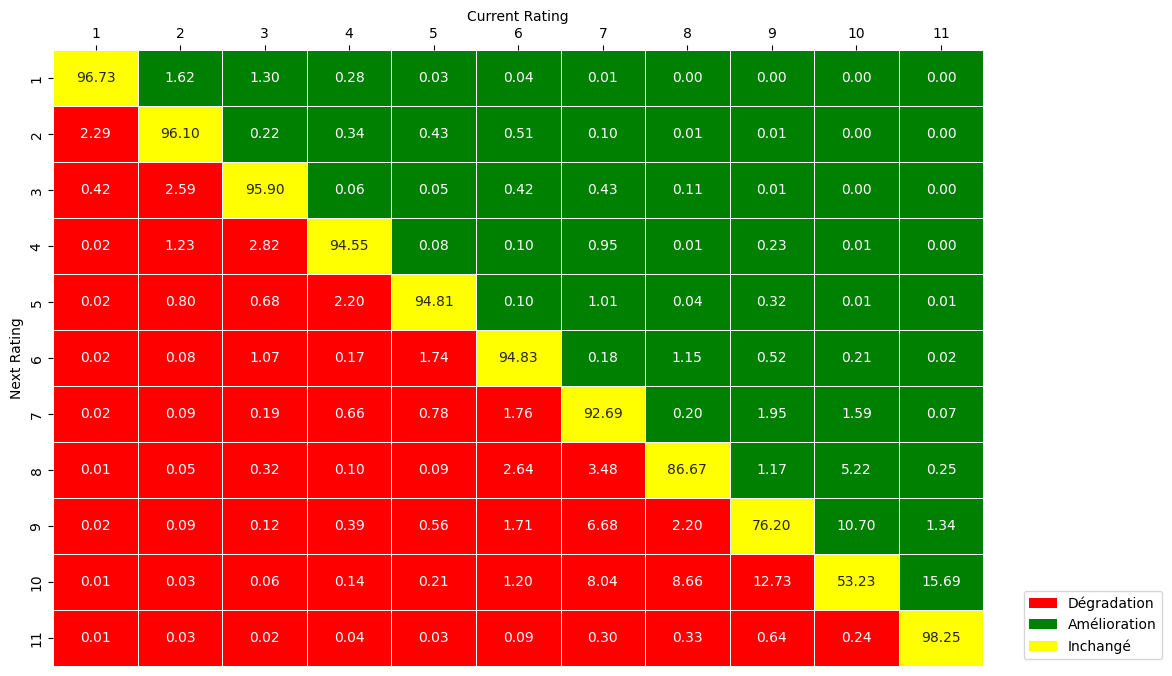

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def display_table(matrix):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Création d'une matrice de couleurs personnalisée
    custom_matrix = np.zeros(matrix.shape)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if i < j:  # Vert pour les notes qui s'améliorent
                custom_matrix[i, j] = 1
            elif i == j:  # Jaune pour les notes qui ne changent pas
                custom_matrix[i, j] = 2
            else:  # Rouge pour les notes qui se dégradent
                custom_matrix[i, j] = 0

    # Création d'une colormap personnalisée
    custom_cmap = ListedColormap(['red', 'green', 'yellow'])

    sns.heatmap(custom_matrix, annot=matrix, fmt=".2f", linewidths=.5, cmap=custom_cmap, vmin=0, vmax=2, cbar=False, ax=ax)

    # Configuration des étiquettes des axes
    ax.set_xlabel("Current Rating")
    ax.set_ylabel("Next Rating")
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    ax.set_xticklabels(np.arange(1, matrix.shape[1] + 1))
    ax.set_yticklabels(np.arange(1, matrix.shape[0] + 1))

    # Ajout de la légende
    legend_elements = [
        Patch(facecolor='red', label='Dégradation'),
        Patch(facecolor='green', label='Amélioration'),
        Patch(facecolor='yellow', label='Inchangé')
    ]
    ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1.2, 0))

    plt.show()

# Exemple d'utilisation avec la matrice de transition
display_table(percentage_matrix)

### Etude statistique de la matrice de migration

Persistence Ratio: Cela mesure la proportion des emprunteurs qui conservent leur notation d'un trimestre à l'autre. Plus ce ratio est élevé, plus votre modèle est stable et fiable. Pour calculer cela, vous pouvez prendre la somme des diagonales de la matrice de transition et diviser par la somme totale de la matrice.

Average Migration: Cela mesure la tendance moyenne de vos emprunteurs à se déplacer d'une note de crédit à l'autre. Pour calculer cela, vous pouvez multiplier chaque élément de la matrice par la distance absolue entre les notes de crédit correspondantes, puis diviser par la somme totale de la matrice.

Concentration Ratio: Cela mesure la proportion de vos emprunteurs dans chaque note de crédit. Pour calculer cela, vous pouvez prendre la somme des colonnes de la matrice de transition, puis diviser par la somme totale de la matrice.

Escalation Ratio: Cela mesure la proportion des emprunteurs qui se déplacent vers des notes de crédit plus élevées. Pour calculer cela, vous pouvez prendre la somme des éléments au-dessus de la diagonale principale de la matrice, puis diviser par la somme totale de la matrice.

Dégradation Ratio: Cela mesure la proportion des emprunteurs qui se déplacent vers des notes de crédit plus basses. Pour calculer cela, vous pouvez prendre la somme des éléments en dessous de la diagonale principale de la matrice, puis diviser par la somme totale de la matrice.

In [32]:
import pandas as pd
import numpy as np
from tabulate import tabulate


# Fonction qui calcule tous les indicateurs
def calculate_indicators(matrix):
    # Persistence Ratio
    persistence_ratio = np.mean(np.diag(matrix))

    # Average Migration
    avg_migration = np.sum(np.abs(np.subtract.outer(np.arange(matrix.shape[0]), np.arange(matrix.shape[1])))*matrix) / np.sum(matrix)

    # Concentration Ratio
    concentration_ratio = np.sum(matrix, axis=0) / np.sum(matrix)

    # Escalation Ratio
    escalation_ratio = np.sum(np.triu(matrix, k=1)) / np.sum(matrix)


    indicators = pd.DataFrame({
        'Persistence Ratio': persistence_ratio,
        'Average Migration': avg_migration,
        'Concentration Ratio': concentration_ratio,
        'Escalation Ratio': escalation_ratio,
    }, index=matrix.index)

    return indicators

# Calcul des indicateurs pour la matrice de référence
indicators = calculate_indicators(reference_matrix)

# Affichage du DataFrame final avec bordures
print(tabulate(indicators, headers='keys', tablefmt='psql'))

+----------+---------------------+---------------------+-----------------------+--------------------+
|   classe |   Persistence Ratio |   Average Migration |   Concentration Ratio |   Escalation Ratio |
|----------+---------------------+---------------------+-----------------------+--------------------|
|        1 |            0.890871 |           0.0393209 |                     1 |           0.493133 |
|        2 |            0.890871 |           0.109826  |                     1 |           0.478113 |
|        3 |            0.890871 |           0.135514  |                     1 |           0.478132 |
|        4 |            0.890871 |           0.09643   |                     1 |           0.496381 |
|        5 |            0.890871 |           0.0874966 |                     1 |           0.496915 |
|        6 |            0.890871 |           0.205335  |                     1 |           0.474868 |
|        7 |            0.890871 |           0.434836  |                     1 |  

Les valeurs de Persistence Ratio sont identiques pour toutes les classes, ce qui s'explique par le fait que le taux de persistance est la probabilité moyenne de rester dans la même classe, peu importe la classe initiale.

Le taux de migration moyen (Average Migration) est relativement faible pour toutes les classes, ce qui indique que les clients ont tendance à rester dans leur classe d'origine.

Le Concentration Ratio est égal à 1 pour toutes les classes, ce qui suggère que les transitions sont uniformément réparties entre toutes les classes de notation.

L'Escalation Ratio est plus élevé pour la classe 10, ce qui suggère que les clients qui quittent cette classe ont tendance à passer à des classes supérieures.

### Scénarios macro

### Scénario adverse

In [149]:
# Copie des données de 2009 à 2017 de la base variables_macroeconomiques
df_macro_regular = variables_macroeconomiques.loc[variables_macroeconomiques['Date'] < '2018-01-01'].copy()
df_adverse_18_19=variables_macroeconomiques_adverse.loc[variables_macroeconomiques_adverse['Date'] > '2018-01-01'].copy()
df_adverse_18_19=variables_macroeconomiques_adverse.loc[variables_macroeconomiques_adverse['Date'] < '2020-01-01'].copy()
# Récupération des valeurs pour 2018 et 2019 de la base variables_macroeconomiques
df_macro_18_19 = variables_macroeconomiques.loc[variables_macroeconomiques['Date'] > '2018-01-01'].copy()
df_macro_18_19 = df_macro_18_19.loc[df_macro_18_19['Date'] < '2020-01-01'].copy()

for col in df_macro_18_19.columns[1:]:
    df_macro_18_19[col] = df_macro_18_19[col] * (1 + df_adverse_18_19[col].values/100)

# Concaténation de df_macro_regular et df_macro_18_19
df_macro_adverse = pd.concat([df_macro_regular, df_macro_18_19], ignore_index=True)

df_adverse = pd.merge(df_macro_adverse, default_rate_quarterly, on='Date')

In [150]:
#Traitement

df_adverse['DD'] = df_adverse['DR']

def partial_differencing(beta, series):
    return series - beta * series.shift(1)

beta_optimal = 0.84
df_adverse['DD_diff'] = partial_differencing(beta_optimal, df_adverse['DD']).dropna()
df_adverse.dropna(inplace=True)

In [151]:
#Traitement

def partial_differencing(beta, series):
    return series - beta * series.shift(1)

beta_optimal = 0.84
df_adverse['DD_diff'] = partial_differencing(beta_optimal, df_adverse['DD']).dropna()
df_adverse.dropna(inplace=True)

max_lags = 4
lags = np.arange(1, max_lags+1)
macro_vars = ['RGDP', 'HICP', 'RREP', 'IRLT', 'UNR']
best_lags = {}

for var in macro_vars:
    max_corr = 0
    best_lag = 0
    for lag in lags:
        df_adverse[f'{var}_lag{lag}'] = df_adverse[var].shift(lag)
        corr = df_adverse['DD_diff'].corr(df_adverse[f'{var}_lag{lag}'])
        if abs(corr) > abs(max_corr):
            max_corr = corr
            best_lag = lag
    best_lags[var] = best_lag

# Création des colonnes retardées pour DD_diff
df_adverse['DD_diff_lag1'] = df_adverse['DD_diff'].shift(1)
df_adverse['DD_diff_lag2'] = df_adverse['DD_diff'].shift(2)
df_adverse=df_adverse.dropna()
df_adverse=df_adverse.drop(['DR','DD'], axis=1)

In [152]:
import statsmodels.api as sm
from itertools import chain, combinations
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def BMA(X_train, y_train, X_test, y_test, selected_vars, N):
    # Génération de toutes les combinaisons de variables sélectionnées
    variable_combinations = list(chain(*map(lambda x: combinations(selected_vars, x), range(1, len(selected_vars) + 1))))

    def fit_and_score_model(variables, X_train, y_train, X_test, y_test):
        X_train = sm.add_constant(X_train[list(variables)])
        X_test = sm.add_constant(X_test[list(variables)])
        model = sm.OLS(y_train, X_train)
        results = model.fit()
        y_pred = results.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        return {
            'R2': r2,
            'MSE': mse,
            'params': results.params,
            'used_columns': list(variables),
        }


    # Entraînement du modèle OLS pour chaque combinaison de variables et calcule des statistiques
    models_and_stats = [fit_and_score_model(vars, X_train, y_train, X_test, y_test) for vars in variable_combinations]

    # Trier les modèles par R2 décroissant
    models_and_stats.sort(key=lambda x: x['R2'], reverse=True)

    # Sélection des N meilleurs modèles en fonction de R2
    top_n_models_and_stats = models_and_stats[:N]

    # Calcul des poids pour le BMA en utilisant le R2
    weights = np.array([model_stats['R2'] for model_stats in top_n_models_and_stats])
    weights = weights / weights.sum()

    # Prédiction des valeurs pour l'ensemble de test en utilisant le BMA
    y_bma = np.zeros(y_test.shape)
    for i, model_stats in enumerate(top_n_models_and_stats):
        X_test_bma = sm.add_constant(X_test[model_stats['used_columns']])
        y_bma += weights[i] * model_stats['params'].dot(X_test_bma.T)

    # Calcul de R2 et MSE pour le BMA
    r2_bma = r2_score(y_test, y_bma)
    mse_bma = mean_squared_error(y_test, y_bma)

    # Affichage des résultats pour chaque modèle
    for i, model_stats in enumerate(top_n_models_and_stats):
        print(f"Modèle {i+1}:")
        print(f"Variables explicatives utilisées : {model_stats['used_columns']}")
        print(f"R2 : {model_stats['R2']:.4f}")
        #print(f"MSE : {model_stats['MSE']:.4f}")
        print("")

    # Affichage du R2 et MSE pour le modèle BMA
    print(f"R2 pour le modèle BMA : {r2_bma:>6.4f}")
    #print(f"MSE pour le modèle BMA : {mse_bma:>6.4f}")


    return y_bma

In [153]:
# Préparation des données
X = df_adverse.drop(columns=['DD_diff', 'Date'])
y = df_adverse['DD_diff']


# Séparation des données en ensembles d'entraînement et de test pour prédire sur la dernière année 2019
train_df = df_adverse[df_adverse['Date'] < '2019-01-01']
test_df = df_adverse[df_adverse['Date'] >= '2019-01-01']

X_train = train_df.drop(columns=['DD_diff', 'Date'])
y_train = train_df['DD_diff']

X_test = test_df.drop(columns=['DD_diff', 'Date'])
y_test = test_df['DD_diff']

#Variables sélectionnées
selected_vars = ['RGDP', 'RREP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1','DD_diff_lag2']

N=10

In [154]:
y_bma = BMA(X_train, y_train, X_test, y_test, selected_vars, N)

Modèle 1:
Variables explicatives utilisées : ['RREP', 'UNR', 'HICP_lag4', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1', 'DD_diff_lag2']
R2 : 0.7270

Modèle 2:
Variables explicatives utilisées : ['RREP', 'UNR', 'RGDP_lag1', 'HICP_lag4', 'RREP_lag4', 'DD_diff_lag1', 'DD_diff_lag2']
R2 : 0.7175

Modèle 3:
Variables explicatives utilisées : ['RREP', 'HICP_lag4', 'RREP_lag4', 'DD_diff_lag1', 'DD_diff_lag2']
R2 : 0.7091

Modèle 4:
Variables explicatives utilisées : ['RREP', 'UNR', 'RGDP_lag1', 'HICP_lag4', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1', 'DD_diff_lag2']
R2 : 0.6986

Modèle 5:
Variables explicatives utilisées : ['RREP', 'UNR', 'HICP_lag4', 'RREP_lag4', 'DD_diff_lag1', 'DD_diff_lag2']
R2 : 0.6946

Modèle 6:
Variables explicatives utilisées : ['RREP', 'UNR', 'RGDP_lag1', 'HICP_lag4', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1']
R2 : 0.6931

Modèle 7:
Variables explicatives utilisées : ['RREP', 'UNR', 'HICP_lag4', 'RREP_lag4', 'DD_diff_lag1']
R2 : 0.6875

Modèle 8:
Variables explicatives utilisé

In [138]:
print(y_bma)

36    0.004938
37    0.003679
38    0.005558
39    0.003229
dtype: float64


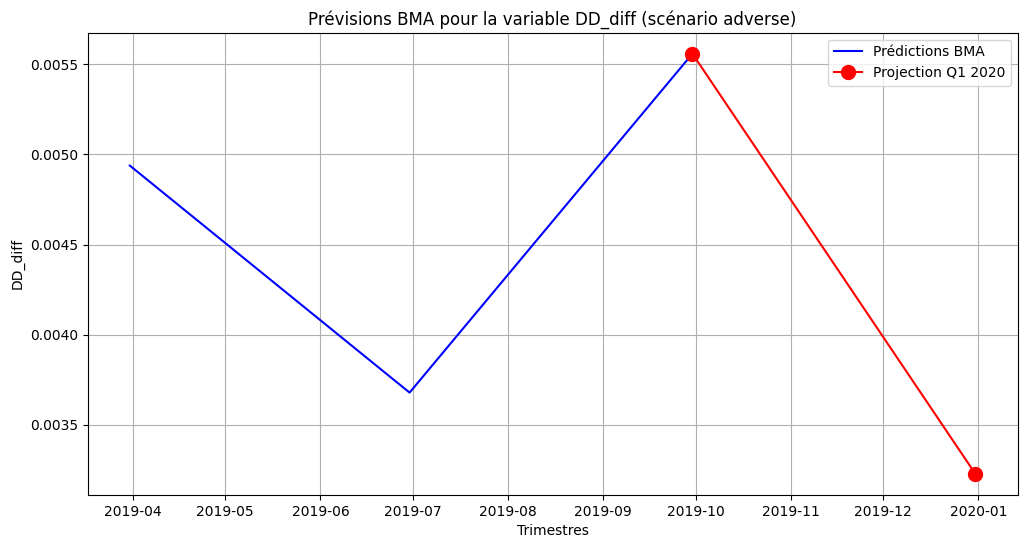

In [156]:
import matplotlib.pyplot as plt
import pandas as pd

# Les dates des 4 derniers trimestres de 2019 et Q1 2020
dates = ['2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31']

# Les prédictions BMA et la projection pour Q1 2020
y_bma_updated = list(y_bma) 

# Création d'un DataFrame avec les dates et les prédictions
predictions_df = pd.DataFrame({'Date': dates, 'Predictions': y_bma_updated})
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(12, 6))

# Tracé des prédictions BMA pour les 4 premiers trimestres
ax.plot(predictions_df['Date'][:-1], predictions_df['Predictions'][:-1], label='Prédictions BMA', color='blue')

# Tracé de la projection pour le dernier trimestre
ax.plot(predictions_df['Date'][-2:], predictions_df['Predictions'][-2:], marker='o', markersize=10, color='red', label='Projection Q1 2020')

# Paramètres du graphique
ax.set_xlabel('Trimestres')
ax.set_ylabel('DD_diff')
ax.set_title('Prévisions BMA pour la variable DD_diff (scénario adverse)')
ax.legend(loc='best')
ax.grid(True)

# Affichage du graphique
plt.show()

### Scénario baseline

In [157]:
# Copie des données de 2009 à 2017 de la base variables_macroeconomiques
df_macro_regular = variables_macroeconomiques.loc[variables_macroeconomiques['Date'] < '2018-01-01'].copy()

df_baseline_18_19=variables_macroeconomiques_baseline.loc[variables_macroeconomiques_baseline['Date'] > '2018-01-01'].copy()
df_baseline_18_19=variables_macroeconomiques_baseline.loc[variables_macroeconomiques_baseline['Date'] < '2020-01-01'].copy()

# Récupération des valeurs pour 2018 et 2019 de la base variables_macroeconomiques
df_macro_18_19 = variables_macroeconomiques.loc[variables_macroeconomiques['Date'] > '2018-01-01'].copy()
df_macro_18_19 = df_macro_18_19.loc[df_macro_18_19['Date'] < '2020-01-01'].copy()

for col in df_macro_18_19.columns[1:]:
    df_macro_18_19[col] = df_macro_18_19[col] * (1 + df_baseline_18_19[col].values/100)

# Concaténation de df_macro_regular et df_macro_18_19
df_macro_baseline = pd.concat([df_macro_regular, df_macro_18_19], ignore_index=True)

df_baseline = pd.merge(df_macro_baseline, default_rate_quarterly, on='Date')

In [158]:
df_baseline

,Date,RGDP,HICP,RREP,IRLT,UNR,DR
0,2010-01-31,401628.8000,92.9000,117.9000,4.00000,8.612495,0.059661
1,2010-04-30,403548.8000,92.2000,118.8000,4.03000,8.413377,0.049995
2,2010-07-31,405763.2000,93.6000,118.9000,3.80000,8.379038,0.049434
3,2010-10-31,407697.5000,92.5000,118.3000,4.73000,7.995356,0.049466
4,2011-01-31,407880.9000,95.6000,120.7000,4.84000,8.027650,0.047990
5,2011-04-30,405749.1000,94.1000,120.3000,5.46000,8.583929,0.047582
6,2011-07-31,401901.7000,97.1000,119.5000,5.97000,9.287924,0.048630
7,2011-10-31,397538.2000,95.6000,119.0000,6.54000,10.203978,0.043486
8,2012-01-31,394602.6000,99.1000,118.1000,5.68000,10.771771,0.043242
9,2012-04-30,392558.0000,97.5000,115.9000,6.00000,10.858623,0.040473


In [159]:
#Traitement

df_baseline['DD'] = df_baseline['DR']

def partial_differencing(beta, series):
    return series - beta * series.shift(1)

beta_optimal = 0.84
df_baseline['DD_diff'] = partial_differencing(beta_optimal, df_baseline['DD']).dropna()
df_baseline.dropna(inplace=True)

In [160]:
#Traitement

def partial_differencing(beta, series):
    return series - beta * series.shift(1)

beta_optimal = 0.84
df_baseline['DD_diff'] = partial_differencing(beta_optimal, df_baseline['DD']).dropna()
df_baseline.dropna(inplace=True)

max_lags = 4
lags = np.arange(1, max_lags+1)
macro_vars = ['RGDP', 'HICP', 'RREP', 'IRLT', 'UNR']
best_lags = {}

for var in macro_vars:
    max_corr = 0
    best_lag = 0
    for lag in lags:
        df_baseline[f'{var}_lag{lag}'] = df_baseline[var].shift(lag)
        corr = df_baseline['DD_diff'].corr(df_baseline[f'{var}_lag{lag}'])
        if abs(corr) > abs(max_corr):
            max_corr = corr
            best_lag = lag
    best_lags[var] = best_lag

# Création des colonnes retardées pour DD_diff
df_baseline['DD_diff_lag1'] = df_baseline['DD_diff'].shift(1)
df_baseline['DD_diff_lag2'] = df_baseline['DD_diff'].shift(2)
df_baseline=df_baseline.dropna()
df_baseline=df_baseline.drop(['DR','DD'], axis=1)

In [161]:
import statsmodels.api as sm
from itertools import chain, combinations
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def BMA(X_train, y_train, X_test, y_test, selected_vars, N):
    # Génération de toutes les combinaisons de variables sélectionnées
    variable_combinations = list(chain(*map(lambda x: combinations(selected_vars, x), range(1, len(selected_vars) + 1))))

    def fit_and_score_model(variables, X_train, y_train, X_test, y_test):
        X_train = sm.add_constant(X_train[list(variables)])
        X_test = sm.add_constant(X_test[list(variables)])
        model = sm.OLS(y_train, X_train)
        results = model.fit()
        y_pred = results.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        return {
            'R2': r2,
            'MSE': mse,
            'params': results.params,
            'used_columns': list(variables),
        }


    # Entraînement du modèle OLS pour chaque combinaison de variables et calcule des statistiques
    models_and_stats = [fit_and_score_model(vars, X_train, y_train, X_test, y_test) for vars in variable_combinations]

    # Trier les modèles par R2 décroissant
    models_and_stats.sort(key=lambda x: x['R2'], reverse=True)

    # Sélection des N meilleurs modèles en fonction de R2
    top_n_models_and_stats = models_and_stats[:N]

    # Calcul des poids pour le BMA en utilisant le R2
    weights = np.array([model_stats['R2'] for model_stats in top_n_models_and_stats])
    weights = weights / weights.sum()

    # Prédiction des valeurs pour l'ensemble de test en utilisant le BMA
    y_bma = np.zeros(y_test.shape)
    for i, model_stats in enumerate(top_n_models_and_stats):
        X_test_bma = sm.add_constant(X_test[model_stats['used_columns']])
        y_bma += weights[i] * model_stats['params'].dot(X_test_bma.T)

    # Calcul de R2 et MSE pour le BMA
    r2_bma = r2_score(y_test, y_bma)
    mse_bma = mean_squared_error(y_test, y_bma)

    # Affichage des résultats pour chaque modèle
    for i, model_stats in enumerate(top_n_models_and_stats):
        print(f"Modèle {i+1}:")
        print(f"Variables explicatives utilisées : {model_stats['used_columns']}")
        print(f"R2 : {model_stats['R2']:.4f}")
        #print(f"MSE : {model_stats['MSE']:.4f}")
        print("")

    # Affichage du R2 et MSE pour le modèle BMA
    print(f"R2 pour le modèle BMA : {r2_bma:>6.4f}")
    #print(f"MSE pour le modèle BMA : {mse_bma:>6.4f}")


    return y_bma

In [162]:
# Préparation des données
X = df_baseline.drop(columns=['DD_diff', 'Date'])
y = df_baseline['DD_diff']


# Séparation des données en ensembles d'entraînement et de test pour prédire sur la dernière année 2019
train_df = df_baseline[df_baseline['Date'] < '2019-01-01']
test_df = df_baseline[df_baseline['Date'] >= '2019-01-01']

X_train = train_df.drop(columns=['DD_diff', 'Date'])
y_train = train_df['DD_diff']

X_test = test_df.drop(columns=['DD_diff', 'Date'])
y_test = test_df['DD_diff']

#Variables sélectionnées
selected_vars = ['RGDP', 'RREP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1','DD_diff_lag2']

N=10

In [163]:
y_bma = BMA(X_train, y_train, X_test, y_test, selected_vars, N)

Modèle 1:
Variables explicatives utilisées : ['RGDP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1']
R2 : 0.7153

Modèle 2:
Variables explicatives utilisées : ['RREP', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'DD_diff_lag2']
R2 : 0.7080

Modèle 3:
Variables explicatives utilisées : ['RREP', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'DD_diff_lag2']
R2 : 0.7073

Modèle 4:
Variables explicatives utilisées : ['RGDP', 'IRLT', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'UNR_lag1', 'DD_diff_lag1']
R2 : 0.6734

Modèle 5:
Variables explicatives utilisées : ['RGDP', 'UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag1', 'HICP_lag4', 'RREP_lag3', 'RREP_lag4', 'UNR_lag1', 'DD_diff_lag1']
R2 : 0.6720

Modèle 6:
Variables explicatives utilisées : ['UNR', 'RGDP_lag1', 'RGDP_lag4', 'HICP_lag4', 'RREP_lag3', 'DD_diff_lag2']
R2 : 0.6618

